In [10]:
import os
import xarray as xr
import numpy as np
import xesmf as xe

In [15]:
path = r"C:\Users\Felicio.Cassalho\Work/Modeling/AK_Project/WaveCu_paper/OWI_wind/"
owi_all = xr.concat([xr.open_dataset(path+f"OWI_Alaska_Basin/2019{i:02d}_Region.win.nc", format ='netcdf4') for i in range (6,12)], dim='time')
air_files = os.listdir(path+r"sflux/")
output_dir = r'sflux_era5_owi/'

In [16]:
_, unique_indices = np.unique(owi_all['time'], return_index=True)
owi_all = owi_all.isel(time=unique_indices)

In [17]:
owi = owi_all.rename({
    'latitude': 'ny_grid',
    'longitude': 'nx_grid',
    'u10': 'uwind',
    'v10': 'vwind'
})
lon_2d, lat_2d = np.meshgrid(owi['nx_grid'].values, owi['ny_grid'].values)
owi = owi.assign_coords(
    lon=(('ny_grid', 'nx_grid'), lon_2d.astype(np.float32)),
    lat=(('ny_grid', 'nx_grid'), lat_2d.astype(np.float32))
)

In [18]:
for i,air_file in enumerate(air_files):
    air = xr.open_dataset(path+f"sflux/{air_file}")
    
    owi_time_aligned = owi.interp(time=air.time, method="linear")
    regridder = xe.Regridder(
        owi_time_aligned,
        air,
        "bilinear",
        unmapped_to_nan=True,
        periodic=False
    )

    owi_regridded = regridder(owi_time_aligned[['uwind', 'vwind']])
    merged_ds = air.copy(deep=True)

    merged_ds['uwind'] = xr.where(
        owi_regridded['uwind'].notnull(),
        owi_regridded['uwind'],
        air['uwind']
    )
    
    merged_ds['vwind'] = xr.where(
        owi_regridded['vwind'].notnull(),
        owi_regridded['vwind'],
        air['vwind']
    )

    air = xr.open_dataset(path+f"sflux/{air_file}",decode_times=False)
    merged_ds['time'] = air['time']

    merged_ds.attrs['history'] = f"Original sflux data merged with high-resolution OWI wind fields on {np.datetime64('now', 's')}."
    merged_ds.attrs['source'] = "sflux_air (base) and OWI (inlay)"
    merged_ds.attrs['comment'] = "High-resolution OWI wind data was bilinearly interpolated and used where available."

    merged_ds.to_netcdf(f"{path}{output_dir}/{air_file}")
    

In [20]:
owi_era = xr.open_dataset(f"{path}{output_dir}/sflux_air_1.0001.nc", format ='netcdf4') 

In [21]:
era = xr.open_dataset(f"{path}sflux/sflux_air_1.0001.nc", format ='netcdf4') 

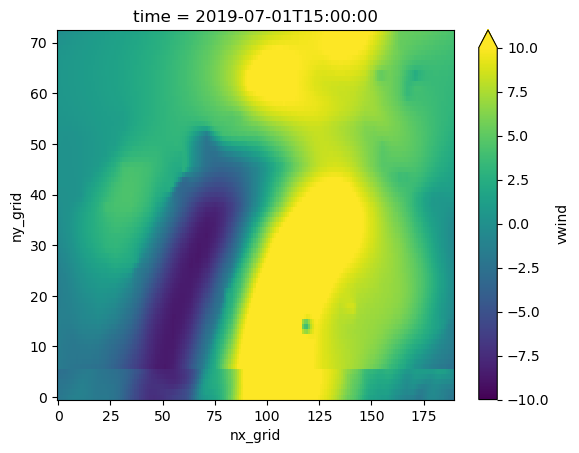

In [67]:
owi_era['vwind'][15].plot(vmin=-10,vmax=10)

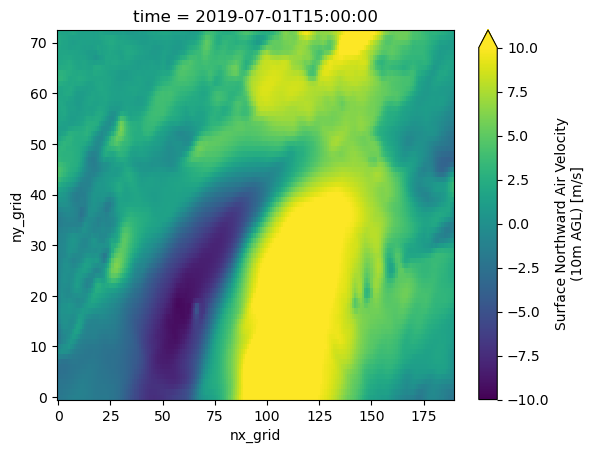

In [68]:
era['vwind'][15].plot(vmin=-10,vmax=10)

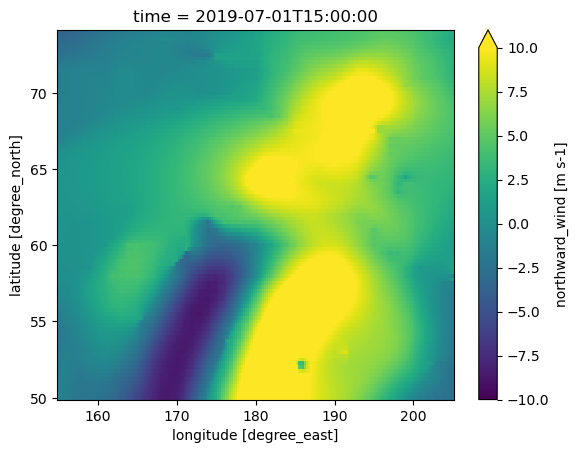

In [69]:
owi_all['v10'][240+5].plot(vmin=-10,vmax=10)